In [16]:
%load_ext dotenv
%dotenv
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
# import tensorflow as tf
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ["PYTHONWARNINGS"] = "ignore"

s3_client = boto3.client(
    's3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
)
BUCKET_NAME = 'tnn-hse-medtech'
DATASET_DIR = 'datasets/'

In [2]:
data = pd.read_csv('normalized_data.csv')

In [3]:
data

expert  ...                               relative_path
0      MedicalExpert-I  ...    MedicalExpert-I/0Normal/NormalG0 (1).png
1      MedicalExpert-I  ...   MedicalExpert-I/0Normal/NormalG0 (10).png
2      MedicalExpert-I  ...  MedicalExpert-I/0Normal/NormalG0 (100).png
3      MedicalExpert-I  ...  MedicalExpert-I/0Normal/NormalG0 (101).png
4      MedicalExpert-I  ...  MedicalExpert-I/0Normal/NormalG0 (102).png
...                ...  ...                                         ...
3273  MedicalExpert-II  ...  MedicalExpert-II/4Severe/SevereG4 (95).png
3274  MedicalExpert-II  ...  MedicalExpert-II/4Severe/SevereG4 (96).png
3275  MedicalExpert-II  ...  MedicalExpert-II/4Severe/SevereG4 (97).png
3276  MedicalExpert-II  ...  MedicalExpert-II/4Severe/SevereG4 (98).png
3277  MedicalExpert-II  ...  MedicalExpert-II/4Severe/SevereG4 (99).png

[3278 rows x 4 columns]

In [5]:
from pathlib import Path

from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import PIL

IMAGE_DIRECTORY = Path('.') / 'images'

@dataclass()
class Metadata:
    severity: int
    relative_path: str
    path: Path
    width: int
    height: int
    size: int

def handle_file(item) -> Metadata:
    path = IMAGE_DIRECTORY / item.relative_path
    path.parent.mkdir(parents=True, exist_ok=True)
    s3_client.download_file(BUCKET_NAME, f'{DATASET_DIR}{item.relative_path}', str(path))
    with PIL.Image.open(str(path)) as im:
        width, height = im.size
    return Metadata(item.severity, item.relative_path, path, width, height, size=path.stat().st_size)

raw_data = []
with ThreadPoolExecutor(max_workers=100) as pool:
    for item in tqdm(pool.map(handle_file, data.itertuples(), chunksize=1), total=len(data)):
        raw_data.append(item)

  0%|          | 0/3278 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame(raw_data)
df

severity                               relative_path  ... height   size
0            0    MedicalExpert-I/0Normal/NormalG0 (1).png  ...    162  31193
1            0   MedicalExpert-I/0Normal/NormalG0 (10).png  ...    162  34614
2            0  MedicalExpert-I/0Normal/NormalG0 (100).png  ...    162  33982
3            0  MedicalExpert-I/0Normal/NormalG0 (101).png  ...    162  28115
4            0  MedicalExpert-I/0Normal/NormalG0 (102).png  ...    162  31167
...        ...                                         ...  ...    ...    ...
3273         4  MedicalExpert-II/4Severe/SevereG4 (95).png  ...    162  28841
3274         4  MedicalExpert-II/4Severe/SevereG4 (96).png  ...    162  32913
3275         4  MedicalExpert-II/4Severe/SevereG4 (97).png  ...    162  34643
3276         4  MedicalExpert-II/4Severe/SevereG4 (98).png  ...    162  30874
3277         4  MedicalExpert-II/4Severe/SevereG4 (99).png  ...    162  35121

[3278 rows x 6 columns]

In [70]:
df.groupby(['width', 'height']).size()

width  height
300    162       2916
640    161        362
dtype: int64

In [7]:
double = df[df.width == 640]
single = df[df.width == 300]
single

severity                               relative_path  ... height   size
0            0    MedicalExpert-I/0Normal/NormalG0 (1).png  ...    162  31193
1            0   MedicalExpert-I/0Normal/NormalG0 (10).png  ...    162  34614
2            0  MedicalExpert-I/0Normal/NormalG0 (100).png  ...    162  33982
3            0  MedicalExpert-I/0Normal/NormalG0 (101).png  ...    162  28115
4            0  MedicalExpert-I/0Normal/NormalG0 (102).png  ...    162  31167
...        ...                                         ...  ...    ...    ...
3273         4  MedicalExpert-II/4Severe/SevereG4 (95).png  ...    162  28841
3274         4  MedicalExpert-II/4Severe/SevereG4 (96).png  ...    162  32913
3275         4  MedicalExpert-II/4Severe/SevereG4 (97).png  ...    162  34643
3276         4  MedicalExpert-II/4Severe/SevereG4 (98).png  ...    162  30874
3277         4  MedicalExpert-II/4Severe/SevereG4 (99).png  ...    162  35121

[2916 rows x 6 columns]

In [8]:
%pip install torch torchvision #--index-url https://download.pytorch.org/whl/cpu

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
%pip install torchsummary opencv-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import torch
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import v2
from pathlib import Path
from PIL import Image
import cv2
import numpy as np

def loader(path):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if image.dtype == np.uint16:
        image = (image / 256)
    img = Image.fromarray(image.astype("uint8"))
    return img


SINGLE_PATH = Path('.') / 'single'
# for item in single.itertuples():
#     directory = SINGLE_PATH / str(item.severity)
#     directory.mkdir(parents=True, exist_ok=True)
#     new_path =  directory / Path(item.path.name)
#     Path(item.path).rename(new_path)

train_transforms = transforms.Compose([
    transforms.v2.Grayscale(num_output_channels=1),
    transforms.v2.Resize((81, 150)),
    transforms.v2.RandomHorizontalFlip(p=0.5),
    transforms.v2.RandomInvert(),
    transforms.v2.RandomAdjustSharpness(sharpness_factor=2),
    transforms.v2.RandomAutocontrast(),
    v2.ToImage(),
    transforms.v2.ConvertImageDtype(),
    transforms.v2.Normalize((0.5,), (0.5,))
])
dataset = ImageFolder(SINGLE_PATH, transform=train_transforms, loader=loader)
dataset_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=1, 
    persistent_workers=True,
)


In [3]:
dataiter = iter(dataset_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(-1.) tensor(1.)


In [3]:
class TorchConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 2048, 3, stride=2, padding=1), # -> N, 16, 150, 81
            nn.ReLU(),
            nn.Conv2d(2048, 2048, 3, stride=2, padding=1), # -> N, 32, 75, 41
            nn.ReLU(),
            nn.Conv2d(2048, 2048, 3, stride=2, padding=1), # -> N, 32, 75, 41
            nn.ReLU(),
            nn.Conv2d(2048, 2048, 3, stride=2, padding=1), # -> N, 32, 75, 41
            nn.ReLU(),
            nn.BatchNorm2d(2048),
            nn.Conv2d(2048, 2048, 3, stride=2, padding=1), # -> N, 64, 38, 21
            nn.ReLU(),
            nn.BatchNorm2d(2048),
            nn.Conv2d(2048, 2048, 3, stride=2, padding=1), # -> N, 128, 19, 11
            nn.ReLU(),
            nn.Conv2d(2048, 2048, 3, stride=2, padding=1), # -> N, 32, 75, 41
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4096, 2048),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.Unflatten(1, (2048, 1, 2)),
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 2048, 3, stride=2, padding=1, output_padding=[1, 0]), # -> N, 128, 19, 11
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 2048, 3, stride=2, padding=1, output_padding=[0, 0]), # -> N, 64, 38, 21
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 2048, 3, stride=2, padding=1, output_padding=[1, 1]),
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 2048, 3, stride=2, padding=1, output_padding=[0, 0]), # -> N, 32, 75, 41
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 2048, 3, stride=2, padding=1, output_padding=[0, 1]), # -> N, 16, 150, 81
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 2048, 3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 1, 3, stride=2, padding=1, output_padding=[0, 1]), # -> N, 1, 300, 162
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [109]:
model = TorchConvAutoEncoder()
model.to(torch.device('cuda'))
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [82]:
from torchsummary import summary
model.to(torch.device('cuda'))
summary(model.encoder, (1, 81, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 2048, 41, 75]          20,480
              ReLU-2         [-1, 2048, 41, 75]               0
            Conv2d-3         [-1, 2048, 21, 38]      37,750,784
              ReLU-4         [-1, 2048, 21, 38]               0
            Conv2d-5         [-1, 2048, 11, 19]      37,750,784
              ReLU-6         [-1, 2048, 11, 19]               0
            Conv2d-7          [-1, 2048, 6, 10]      37,750,784
              ReLU-8          [-1, 2048, 6, 10]               0
       BatchNorm2d-9          [-1, 2048, 6, 10]           4,096
           Conv2d-10           [-1, 2048, 3, 5]      37,750,784
             ReLU-11           [-1, 2048, 3, 5]               0
      BatchNorm2d-12           [-1, 2048, 3, 5]           4,096
           Conv2d-13           [-1, 2048, 2, 3]      37,750,784
             ReLU-14           [-1, 204

In [110]:
summary(model.decoder, (2048,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]       8,392,704
         Unflatten-2           [-1, 2048, 1, 2]               0
              ReLU-3           [-1, 2048, 1, 2]               0
   ConvTranspose2d-4           [-1, 2048, 2, 3]      37,750,784
              ReLU-5           [-1, 2048, 2, 3]               0
   ConvTranspose2d-6           [-1, 2048, 3, 5]      37,750,784
              ReLU-7           [-1, 2048, 3, 5]               0
   ConvTranspose2d-8          [-1, 2048, 6, 10]      37,750,784
              ReLU-9          [-1, 2048, 6, 10]               0
  ConvTranspose2d-10         [-1, 2048, 11, 19]      37,750,784
             ReLU-11         [-1, 2048, 11, 19]               0
  ConvTranspose2d-12         [-1, 2048, 21, 38]      37,750,784
             ReLU-13         [-1, 2048, 21, 38]               0
  ConvTranspose2d-14         [-1, 2048,

In [119]:
from tqdm.notebook import tqdm

num_epochs = 200
scaler = torch.cuda.amp.GradScaler() 
model.to(torch.device('cuda'))
with tqdm(total=num_epochs*len(dataset_loader)) as pbar:
    for epoch in range(num_epochs):
        for img, _ in dataset_loader:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(dtype=torch.float16):
                img = img.to(torch.device('cuda'))
                recon = model(img)
                loss = criterion(recon, img)
            # loss.backward()
            # optimizer.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            pbar.update(1)
        print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')



  0%|          | 0/2200 [00:00<?, ?it/s]

Epoch: 1, Loss: 5019.1172
Epoch: 2, Loss: 4699.0986
Epoch: 3, Loss: 6260.4663
Epoch: 4, Loss: 4650.6367
Epoch: 5, Loss: 6124.1113
Epoch: 6, Loss: 4975.8765
Epoch: 7, Loss: 6280.9170
Epoch: 8, Loss: 5267.9678
Epoch: 9, Loss: 5306.6675
Epoch: 10, Loss: 5335.3369
Epoch: 11, Loss: 5614.5464
Epoch: 12, Loss: 5403.5293
Epoch: 13, Loss: 5176.5342
Epoch: 14, Loss: 4901.3003
Epoch: 15, Loss: 5068.4180
Epoch: 16, Loss: 7298.1709
Epoch: 17, Loss: 5186.9985
Epoch: 18, Loss: 5434.9087
Epoch: 19, Loss: 4555.8379
Epoch: 20, Loss: 4926.8926
Epoch: 21, Loss: 4549.1660
Epoch: 22, Loss: 4851.9561
Epoch: 23, Loss: 4513.7544
Epoch: 24, Loss: 4607.8877
Epoch: 25, Loss: 3850.5972
Epoch: 26, Loss: 4634.0801
Epoch: 27, Loss: 4553.5254
Epoch: 28, Loss: 4523.5771
Epoch: 29, Loss: 4754.8618
Epoch: 30, Loss: 5496.2236
Epoch: 31, Loss: 5914.3350
Epoch: 32, Loss: 4408.7041
Epoch: 33, Loss: 4490.3115
Epoch: 34, Loss: 4528.0581
Epoch: 35, Loss: 4954.5571
Epoch: 36, Loss: 4651.4102
Epoch: 37, Loss: 4414.1753
Epoch: 38,

In [6]:
%%time
from tqdm.notebook import tqdm

outputs = []
model.to(torch.device('cpu'))
with torch.no_grad():
    for img, t in tqdm(dataset_loader):
        recon = model(img[:10])
        outputs.append((img[:10], recon))
        break

  0%|          | 0/92 [00:00<?, ?it/s]

CPU times: user 1min 23s, sys: 11.6 s, total: 1min 34s
Wall time: 4.25 s


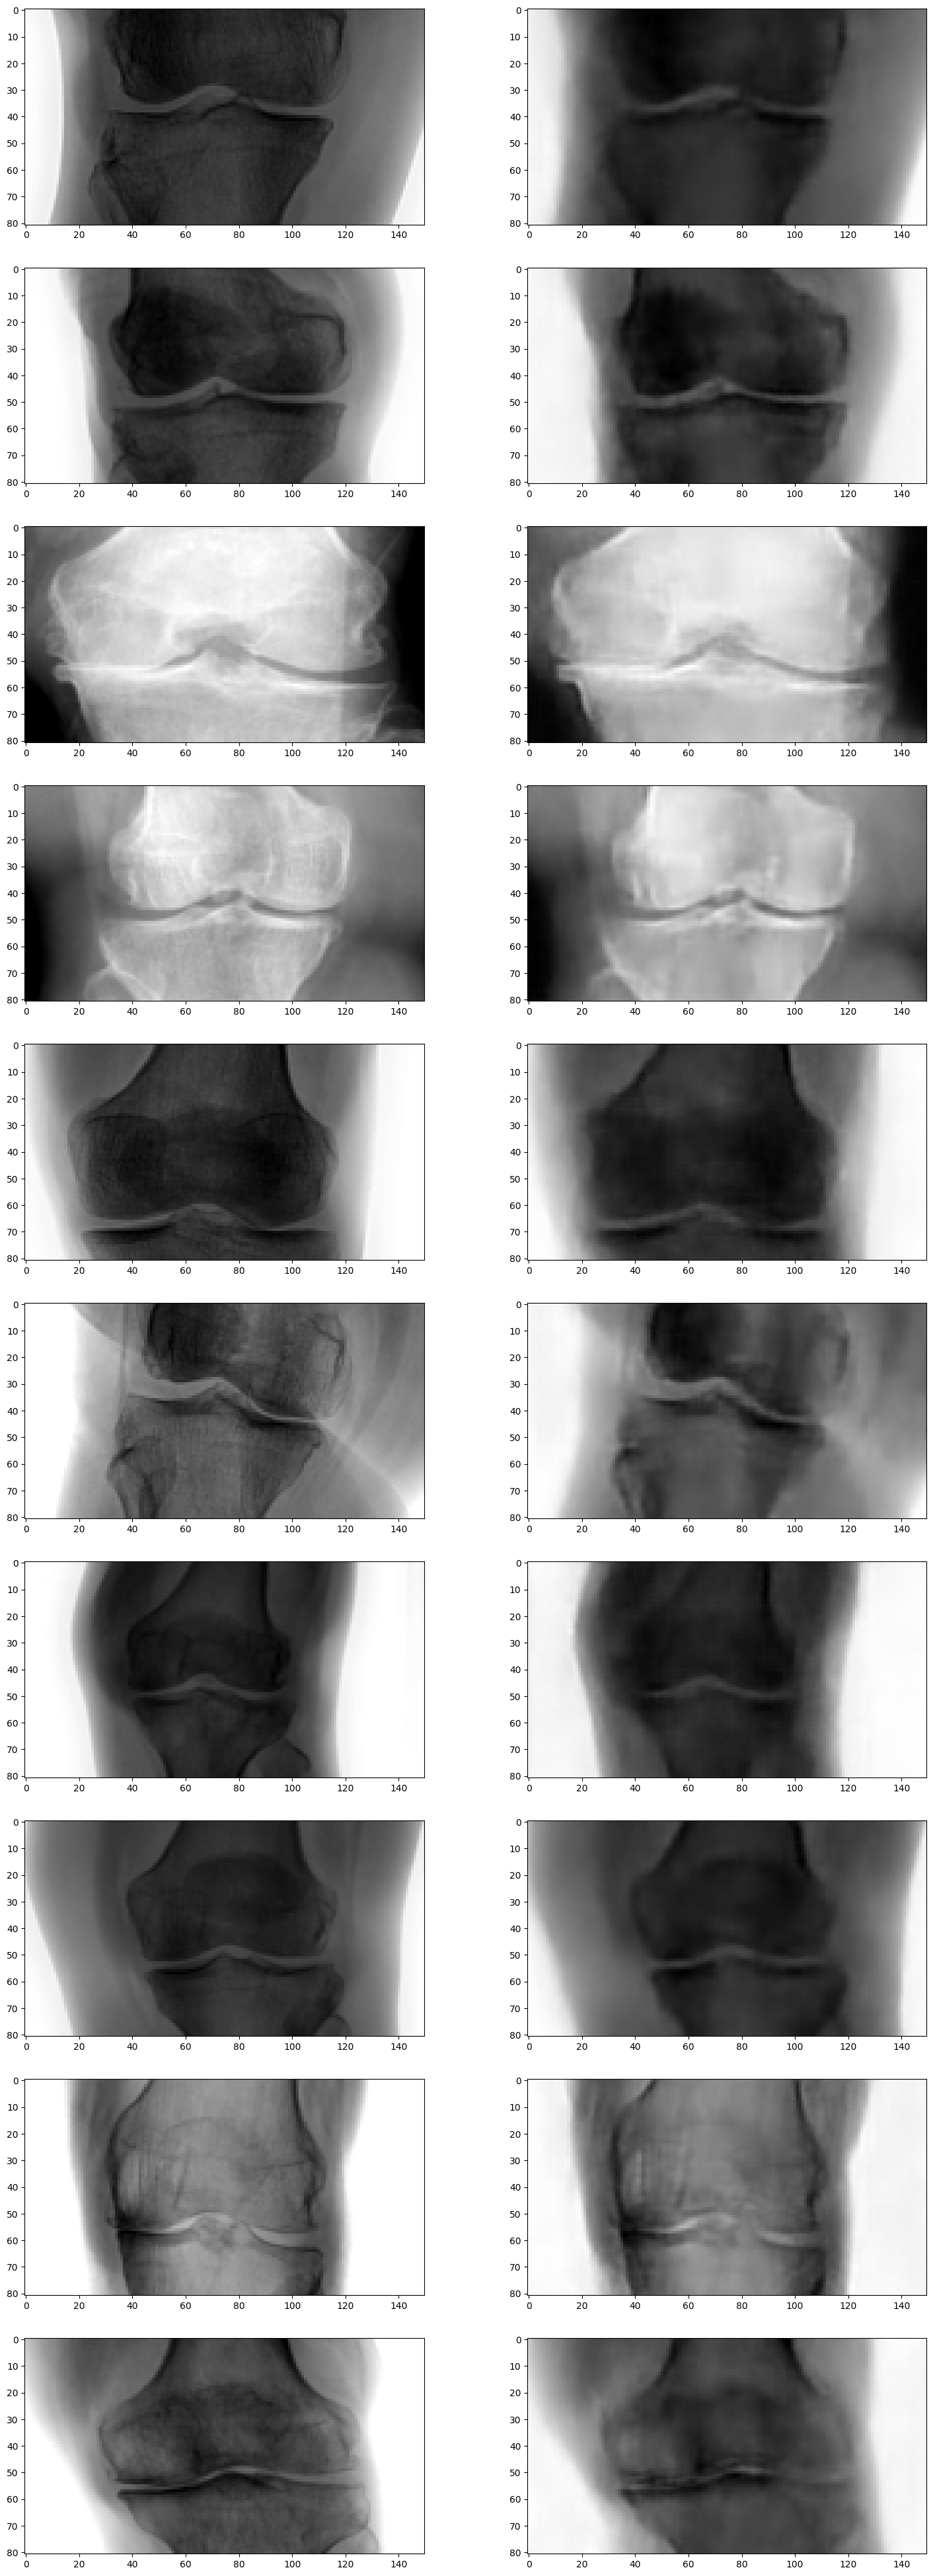

In [52]:
import math
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 50))
plt.gray()
imgs = outputs[0][0].detach().numpy()[:10]
recon = outputs[0][1].detach().numpy()[:10]
# plt.imshow(imgs)
# plt.imshow(recon)
for i, item in enumerate(imgs):
    # print(item)
    plt.subplot(len(imgs), 2, i * 2 +1)
    # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
    # item: 1, 28, 28
    plt.imshow(item[0])

for i, item in enumerate(recon):
    plt.subplot(len(imgs), 2, i*2+2) # row_length + i + 1
    # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
    # item: 1, 28, 28
    plt.imshow(item[0])

In [129]:
import gzip

torch.save(model.state_dict(), 'autoencoder.bin')

In [130]:
s3_client.upload_file('autoencoder.bin', BUCKET_NAME, 'models/autoencoder.bin')

In [4]:
# s3_client.download_file(BUCKET_NAME, 'models/autoencoder.bin', 'autoencoder.bin')
model = TorchConvAutoEncoder()
model.load_state_dict(torch.load('autoencoder.bin'))

<All keys matched successfully>

Считаем дескрипторы для изображений

In [13]:
def loader(path):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if image.dtype == np.uint16:
        image = (image / 256)
    img = Image.fromarray(image.astype("uint8"))
    return img


SINGLE_PATH = Path('.') / 'single'
train_transforms = transforms.Compose([
    transforms.v2.Grayscale(num_output_channels=1),
    transforms.v2.Resize((81, 150)),
    v2.ToImage(),
    transforms.v2.ConvertImageDtype(),
    transforms.v2.Normalize((0.5,), (0.5,))
])
dataset = ImageFolder(SINGLE_PATH, transform=train_transforms, loader=loader)
dataset_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    num_workers=1, 
    persistent_workers=True,
)
descriptors = []
for batch, labels in tqdm(dataset_loader):
    batch_desc = model.encoder(batch)
    for desc, label in zip(batch_desc, labels):
        descriptors.append((desc.detach().numpy(), label))
    

  0%|          | 0/92 [00:00<?, ?it/s]

In [14]:
len(descriptors)

1465

In [17]:
X_data = pd.DataFrame(d[0] for d in descriptors)
y_data = pd.DataFrame(d[1].detach().numpy() for d in descriptors)

In [18]:
X_data

0         1          2          3          4          5     \
0     1.163949 -6.665942   1.579401  -7.755457  -0.217851  -3.695656   
1    -1.091558 -2.400733   8.342754  -3.243938  -5.216913   5.188537   
2     3.264629 -2.069577   4.832298  -4.222451  -2.360767  -0.272103   
3    -1.844313 -1.833778  -1.600786  -7.707907   5.730061   0.604717   
4    -9.553670 -1.502099   6.067395 -11.504536  16.395973   1.762963   
...        ...       ...        ...        ...        ...        ...   
1460 -0.217508  4.079942   2.625643  -2.145447  -0.228934  11.555887   
1461 -4.397749  4.539709   9.136019  -1.315078   1.168848   5.569158   
1462 -2.718765  8.982764  -9.538179   6.838904   3.903216  -0.748482   
1463 -2.050774 -0.656102  -2.739268  -0.849529  -2.392030  -1.552466   
1464 -7.111358 -4.433976  13.603347  -9.843923  14.951143  -4.978703   

           6         7          8          9     ...       2038       2039  \
0     -3.865335  0.116257  -5.527516   4.259705  ...  -5.344927   0.492513   
1      0.756776  3.369485  10.926334   0.364985  ... -11.754509  -0.249016   
2     -4.562030  5.999889   6.288147   2.272424  ...  -9.537007   4.314089   
3     -8.200841 -3.505964  -2.641064  -3.093031  ...  -4.373057   0.035078   
4    -10.022987 -4.497237   0.921307 -11.102125  ...   0.275708 -10.161390   
...         ...       ...        ...        ...  ...        ...        ...   
1460   4.746986  0.581437   8.586479  -6.643438  ...  -7.879673  -5.367691   
1461  -2.939699  1.902105   9.755014  -5.340510  ...  -3.378426  -3.952415   
1462  -8.570549 -9.531330   1.317336  -6.441187  ...  13.106836  11.129678   
1463  -0.349819 -0.782199   2.967546   0.132095  ...  -0.407700   3.591960   
1464  -5.699542  3.085980   6.284136  10.930466  ...  -3.133086   1.556813   

           2040       2041       2042       2043      2044      2045  \
0     10.574858   5.122711  -1.342309   1.004565  0.542654 -1.500036   
1      3.559171  -2.420055 -12.088570   6.786573  1.181753 -9.992216   
2      4.062629  -2.344783  -8.463508   6.045183  0.528691 -6.917868   
3     -2.444508   0.934690   4.336680   2.879438  1.564355 -4.430016   
4     -8.901984   6.901136   7.880172  -3.131423  1.329173 -3.642943   
...         ...        ...        ...        ...       ...       ...   
1460  -2.700090  -1.922533  -7.586266   9.466985 -1.976558 -7.050779   
1461  -6.728416  -0.208499  -6.702805  10.847403  0.250278 -8.025969   
1462 -15.795441  -3.613008   9.494738 -11.664700  4.375106  3.937578   
1463  -1.540527  -1.090953   1.653686  -3.016421  2.034508 -0.166892   
1464   3.331960  14.964705  -2.599885  -6.910016  3.426295  2.896471   

           2046       2047  
0      8.308594   3.659620  
1     16.352108   3.653251  
2     10.934469   5.172617  
3      4.498971   2.247629  
4      7.490195   7.086414  
...         ...        ...  
1460   6.767824   3.778823  
1461   5.831661   5.844057  
1462 -18.428640  -5.784712  
1463  -1.246737  -2.562839  
1464  11.805953  14.801396  

[1465 rows x 2048 columns]

In [20]:
y_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       1465 non-null   int64
dtypes: int64(1)
memory usage: 11.6 KB


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, stratify=y_data)

In [ ]:
import numpy as np
import catboost as cb
from hyperopt import hp, fmin, tpe
from catboost.utils import eval_metric

val_pool = cb.Pool(X_test, y_test)
train_pool = cb.Pool(X_train, y_train)

def hyperopt_objective(params):
    model = cb.CatBoostClassifier(
        loss_function='MultiClass',
        n_estimators=150,
        bootstrap_type='Bernoulli',
        subsample=0.5,
        task_type="GPU",
        devices='0:1',
        **params)
    model.fit(train_pool, verbose=0, eval_set=val_pool)
    y_pred = model.predict_proba(val_pool)
    return -eval_metric(val_pool.get_label(), y_pred, 'AUC')[0]

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'depth': hp.randint('depth', 3, 10),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 100),
}

best = fmin(
    hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=1000,
    trials_save_file='hog_cb_trials.bin',
)